In [20]:
import numpy as np
import matplotlib.pyplot as plt
from pycbc import frame
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.waveform import get_fd_waveform, get_td_waveform
from pycbc.filter import highpass_fir, matched_filter, match
%matplotlib inline

In [21]:
hstrain = frame.read_frame('../Data/H-H1_LOSC_4_V1-1126076416-4096.gwf', 'H1:LOSC-STRAIN')
lstrain = frame.read_frame('../Data/L-L1_LOSC_4_V1-1126076416-4096.gwf', 'L1:LOSC-STRAIN')

In [22]:
hp, hc = get_td_waveform(approximant="IMRPhenomD", mass1=20, mass2=20, delta_t=hstrain.delta_t, f_lower=30, distance = 1000)
fp, fc = get_fd_waveform(approximant="IMRPhenomD", mass1=20, mass2=20, delta_f=hstrain.delta_f, f_lower=30, distance = 1000)

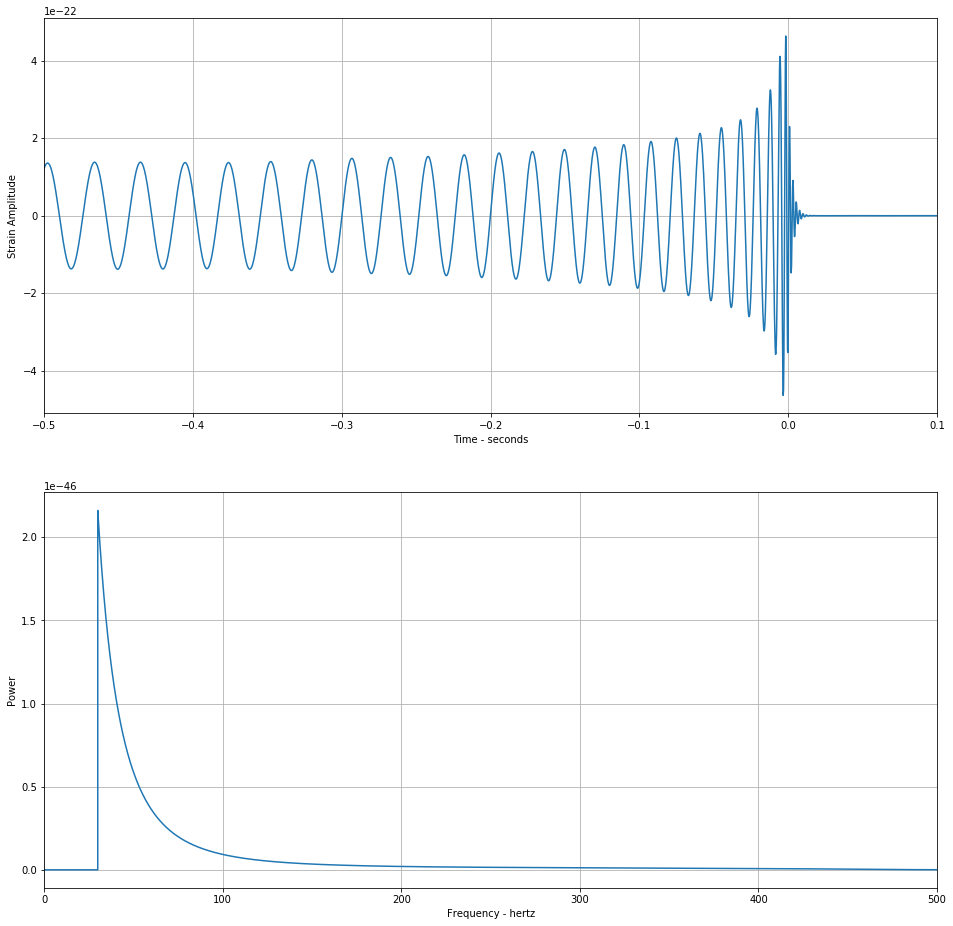

In [23]:
plt.figure(figsize=(16, 16))
plt.subplot(2, 1, 1)
plt.plot(hp.sample_times, hp)
plt.xlim([-0.5, 0.1])
plt.xlabel('Time - seconds')
plt.ylabel('Strain Amplitude')
plt.grid()
plt.subplot(2, 1, 2)
plt.plot(fp.sample_frequencies, fp*np.conj(fp))
plt.xlim([fp.sample_frequencies[0], 500])
plt.xlabel('Frequency - hertz')
plt.ylabel('Power')
plt.grid()

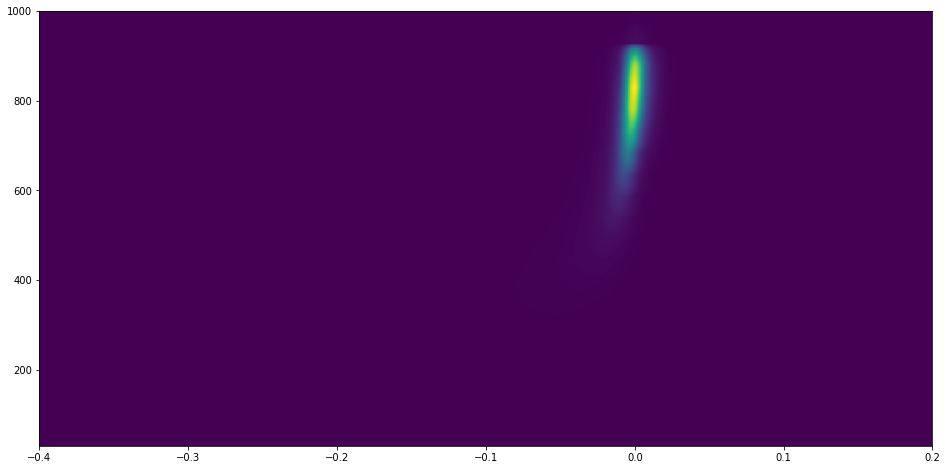

In [24]:
t, f, q = hp.qtransform(hp.delta_t, logfsteps=500, frange=(30, 1000))
plt.figure(figsize=(16, 8))
plt.imshow(q[:, int(-0.4*hp.sample_rate):int(-0.1*hp.sample_rate)]**0.5, cmap='viridis', origin='lower', aspect='auto', extent=[-0.4, t[-1], f[0], f[-1]])

In [25]:
hpsd = hstrain.psd(4)
lpsd = lstrain.psd(4)

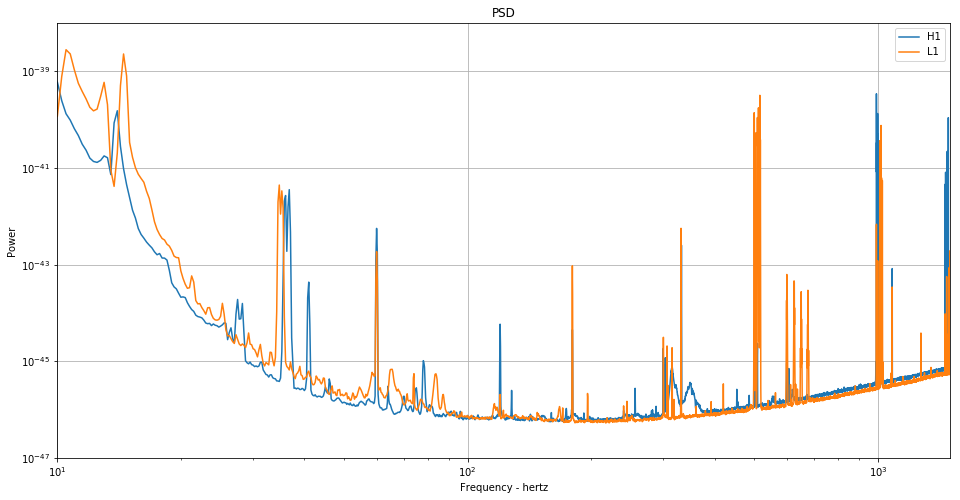

In [26]:
plt.figure(figsize=(16, 8))
plt.title('PSD')
plt.plot(hpsd.sample_frequencies, hpsd, label='H1')
plt.plot(lpsd.sample_frequencies, lpsd, label='L1')
plt.xscale('log')
plt.yscale('log')
plt.xlim([10, 1500])
plt.ylim([1e-47, 1e-38])
plt.xlabel('Frequency - hertz')
plt.ylabel('Power')
plt.legend()
plt.grid()

In [27]:
hwhite = hstrain.whiten(4, 4)

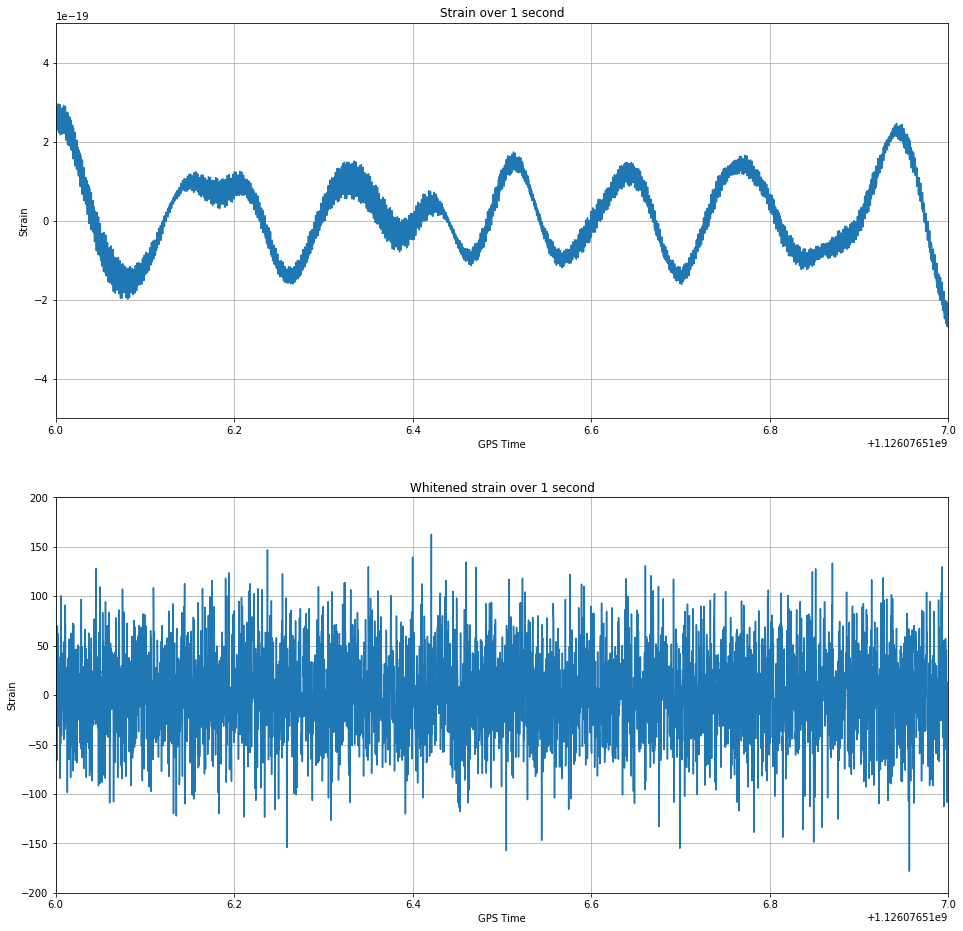

In [28]:
plt.figure(figsize=(16, 16))
plt.subplot(2, 1, 1)
plt.title('Strain over 1 second')
plt.plot(hstrain.sample_times, hstrain)
plt.xlim([hstrain.sample_times[0] + 100, hstrain.sample_times[0] + 101])
plt.ylim([-0.5*10**-18, 0.5*10**-18])
plt.xlabel('GPS Time')
plt.ylabel('Strain')
plt.grid()
plt.subplot(2, 1, 2)
plt.title('Whitened strain over 1 second')
plt.plot(hwhite.sample_times, hwhite)
plt.xlim([hstrain.sample_times[0] + 100, hstrain.sample_times[0] + 101])
plt.ylim([-200, 200])
plt.xlabel('GPS Time')
plt.ylabel('Strain')
plt.grid()

In [29]:
hpsd = interpolate(hpsd, hstrain.delta_f)
hpsd = inverse_spectrum_truncation(hpsd, hstrain.sample_rate * 4, low_frequency_cutoff=15)

temp = hp.copy()
temp.resize(len(hstrain))
temp = temp.cyclic_time_shift(temp.start_time)

snr = np.abs(matched_filter(temp, hstrain, psd=hpsd, low_frequency_cutoff=20))
snr = snr.crop(8, 4)
gt = snr.sample_times[np.argmax(snr)]
gi = np.argmax(hwhite.sample_times > gt)

t, f, q = hwhite[gi-int(hwhite.sample_rate*1):gi+int(hwhite.sample_rate*1)].qtransform(hp.delta_t, logfsteps=500, frange=(30, 1000))

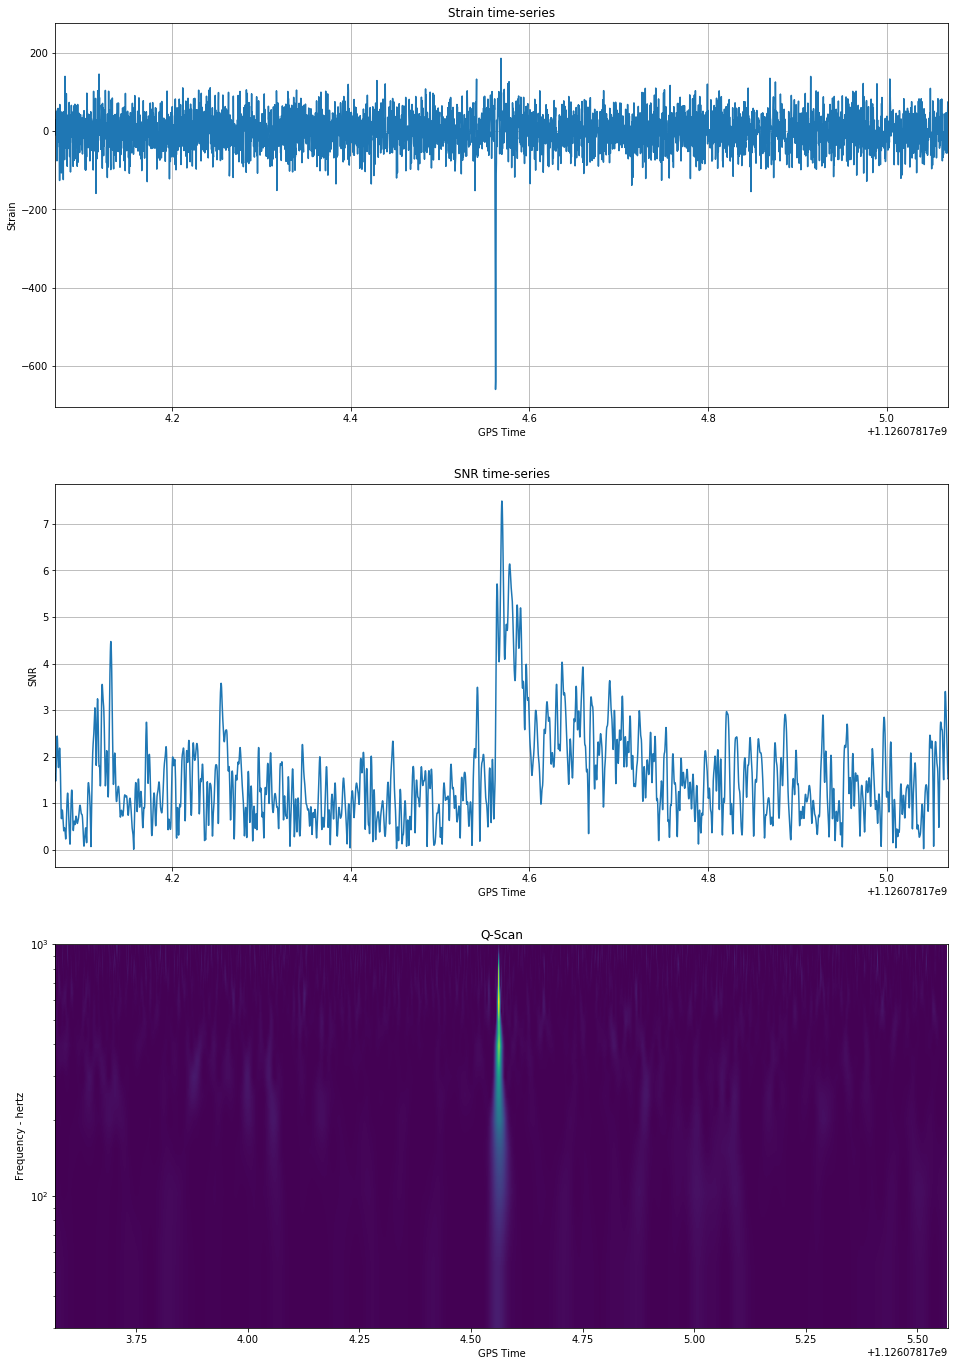

In [30]:
plt.figure(figsize=(16, 24))
plt.subplot(3, 1, 1)
plt.title('Strain time-series')
plt.plot(hwhite.sample_times, hwhite)
plt.xlim([gt - 0.5, gt + 0.5])
plt.xlabel('GPS Time')
plt.ylabel('Strain')
plt.grid()
plt.subplot(3, 1, 2)
plt.title('SNR time-series')
plt.plot(snr.sample_times, snr)
plt.xlim([gt - 0.5, gt + 0.5])
plt.xlabel('GPS Time')
plt.ylabel('SNR')
plt.grid()
plt.subplot(3, 1, 3)
plt.title('Q-Scan')
plt.xlabel('GPS Time')
plt.ylabel('Frequency - hertz')
plt.yscale('log')
plt.imshow(q, cmap='viridis', origin='lower', aspect='auto', extent=[t[0], t[-1], f[0], f[-1]])

In [31]:
hhstrain = hstrain.copy()
hhstrain += temp.cyclic_time_shift(16).numpy()
hhwhite = hhstrain.whiten(4, 4)

hsnr = np.abs(matched_filter(temp, hhstrain, psd=hpsd, low_frequency_cutoff=20))
hsnr = hsnr.crop(8, 4)
st = hhstrain.sample_times[16*hhstrain.sample_rate]
si = np.argmax(hhwhite.sample_times > st)

ht, hf, hq = hhwhite[si-int(hhwhite.sample_rate*1):si+int(hhwhite.sample_rate*1)].qtransform(hp.delta_t, logfsteps=500, frange=(30, 1000))

In [ ]:
plt.figure(figsize=(16, 24))
plt.subplot(3, 1, 1)
plt.title('Strain time-series')
plt.plot(hhwhite.sample_times, hhwhite)
plt.xlim([st - 0.5, st + 0.5])
plt.xlabel('GPS Time')
plt.ylabel('Strain')
plt.grid()
plt.subplot(3, 1, 2)
plt.title('SNR time-series')
plt.plot(hsnr.sample_times, hsnr)
plt.xlim([st - 0.5, st + 0.5])
plt.xlabel('GPS Time')
plt.ylabel('SNR')
plt.grid()
plt.subplot(3, 1, 3)
plt.title('Q-Scan')
plt.xlabel('GPS Time')
plt.ylabel('Frequency - hertz')
plt.yscale('log')
plt.imshow(hq, cmap='viridis', origin='lower', aspect='auto', extent=[ht[0], ht[-1], hf[0], hf[-1]])